In [1]:
!pip install shap
!pip install lime
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3b1247ea210fb4e932b6cdf28cfd9ce493849ac69de3bf7f8c7a0ec797a7d962
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.2 MB/s eta 0:00:00


In [2]:
import shap
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# LIME packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from sklearn.linear_model import Ridge, lars_path
from lime.lime_text import explanation
from functools import partial
import scipy as sp
from sklearn.utils import check_random_state
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install gdown

In [4]:
'''
https://drive.google.com/file/d/1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis/view?usp=drive_link
https://drive.google.com/file/d/1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4/view?usp=drive_link
'''

'\nhttps://drive.google.com/file/d/1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis/view?usp=drive_link\nhttps://drive.google.com/file/d/1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4/view?usp=drive_link\n'

In [5]:
!gdown 1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis
!gdown 1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4

Downloading...
From: https://drive.google.com/uc?id=1Fs0PTy_xPsoX5bg4QTCrX6JAaQCHRzis
To: /content/train.pkl
100% 4.09M/4.09M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JLa-ELhUskQINi0syf3YJWBX8jcCXdn4
To: /content/test.pkl
100% 1.01M/1.01M [00:00<00:00, 96.5MB/s]


In [6]:
FILE_PATH = "train.pkl"

with open(FILE_PATH, 'rb') as f:
    df_train = pickle.load(f)

In [7]:
FILE_PATH = "test.pkl"

with open(FILE_PATH, 'rb') as f:
    df_test = pickle.load(f)

In [8]:
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

In [9]:
df_train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Light Stemming,Root Stemming
0,شايف نفسه الحمار مع انه كان احتياط الموسم الما...,1,شايف نفسه الحمار مع انه كان احتياط الموسم الما...,شايف الحمار انه احتياط الموسم الماضي اليوفي اد...,شايف الحمار انه احتياط الموسم الماضي اليوفي اد...,شيف حمر انه حيط وسم اضي يوف دره ريل امر غرب هج...
1,: هزق البلد كلها ..مرتضي محدش عارف يوقفه ..ل...,1,: هزق البلد كلها ..مرتضي محدش عارف يوقفه ..ل...,هزق البلد مرتضي محدش عارف يوقفه لا وزير داخليه...,هزق البلد مرتضي محدش عارف يوقفه لا وزير داخليه...,هزق بلد رضي حدش عرف وقف لا وزر دخل شبب حتي بتع...
2,استفتاء : عندما تنتهي الاوليمبياد وتعود بعثتنا...,0,استفتاء : عندما تنتهي الاوليمبياد وتعود بعثتنا...,استفتاء تنتهي الاوليمبياد وتعود بعثتنا بالسلام...,استفتاء تنتهي الاوليمبياد وتعود بعثت بالسلامه ...,فاء نهي اوليمبياد تعد بعث سلم يدل حصل وجه نظر
3,Alhashemلا يوجد مخرج لنفط داعش سوي تركيا.هكذا ...,1,Alhashemلا يوجد مخرج لنفط داعش سوي تركيا.هكذا ...,لا يوجد مخرج لنفط داعش سوي تركياهكذا تقول الجغ...,لا يوجد مخرج لنفط داعش سوي تركياهكذا تقول الجغ...,لا وجد خرج نفط دعش سوي تركياهكذا تقل جغراف سؤل...
4,ما احب اركب جاهل معاي السياره عادي اتوتر طول م...,7,ما احب اركب جاهل معاي السياره عادي اتوتر طول م...,احب اركب جاهل معاي السياره عادي اتوتر طول اسوق...,احب اركب جاهل معاي السياره عادي اتوتر طول اسوق...,احب ركب جهل عاي سير عدي وتر طول اسق خيف فرح


In [10]:
label_to_class = [
    'none',
    'anger',
    'joy',
    'sadness',
    'love',
    'sympathy',
    'surprise',
    'fear'
]
label_to_class_dic = {
    0:'none',
    1:'anger',
    2:'joy',
    3:'sadness',
    4:'love',
    5:'sympathy',
    6:'surprise',
    7:'fear'
}

In [11]:
def map_label_to_class(indices, classes):
  return [classes[idx] for idx in indices]

In [12]:
def create_confusion_matrix(y_pred):
  # creatin a confusion matrix
  y_true = map_label_to_class(df_test['label'], label_to_class)
  y_pred = map_label_to_class(y_pred, label_to_class)
  cm = confusion_matrix(y_true, y_pred, labels=label_to_class)
  # create a DataFrame for the confusion matrix with class names as index and columns
  cm_df = pd.DataFrame(cm, index=label_to_class, columns=label_to_class)

  # create a heatmap for visualization
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

## Naive Bayes Model

In [13]:
# use Tfidf Vectorizer root stemming
tfidf_vectorizer_rs = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf_rs = tfidf_vectorizer_rs.fit_transform(df_train['Root Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf_rs = tfidf_vectorizer_rs.transform(df_test['Root Stemming'])

# use Tfidf Vectorizer light stemming
tfidf_vectorizer_ls = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf_ls = tfidf_vectorizer_ls.fit_transform(df_train['Light Stemming'])
# transform the test data using the same vectorizer
X_test_tfidf_ls = tfidf_vectorizer_ls.transform(df_test['Light Stemming'])

## Using MultinomialNB

In [14]:
nb_vec = MultinomialNB(force_alpha=True, alpha=0.1, fit_prior=True)
nb_vec.fit(X_train_tfidf_rs, df_train['label'])

# test accuracy of tf-idf vectorizer
y_pred = nb_vec.predict(X_test_tfidf_rs.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.589170392449081


In [15]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.50      0.76      0.60       307
       anger       0.58      0.72      0.64       276
         joy       0.53      0.35      0.43       268
     sadness       0.43      0.31      0.36       258
        love       0.65      0.69      0.67       250
    sympathy       0.72      0.75      0.74       194
    surprise       0.50      0.27      0.35       201
        fear       0.79      0.79      0.79       259

    accuracy                           0.59      2013
   macro avg       0.59      0.58      0.57      2013
weighted avg       0.58      0.59      0.57      2013



In [16]:
# creatin a confusion matrix
confusion_matrix(df_test['label'], y_pred)

array([[233,  18,  21,  14,   0,   2,  14,   5],
       [ 25, 199,   8,  19,   5,   9,  10,   1],
       [ 71,  21,  95,  16,  34,  11,  11,   9],
       [ 63,  34,   7,  81,  30,  14,  12,  17],
       [  3,  11,  28,  15, 173,  13,   0,   7],
       [  4,  14,   5,  12,   7, 146,   1,   5],
       [ 62,  37,   9,  14,  14,   1,  54,  10],
       [  5,  12,   6,  17,   3,   6,   5, 205]])

In [17]:
nb_vec = MultinomialNB(force_alpha=True, alpha=0.1, fit_prior=True)
nb_vec.fit(X_train_tfidf_ls, df_train['label'])

# test accuracy of tf-idf vectorizer
y_pred = nb_vec.predict(X_test_tfidf_ls.toarray())
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6035767511177347


In [18]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

              precision    recall  f1-score   support

        none       0.49      0.80      0.61       307
       anger       0.63      0.67      0.65       276
         joy       0.55      0.40      0.47       268
     sadness       0.45      0.28      0.35       258
        love       0.64      0.70      0.67       250
    sympathy       0.77      0.78      0.78       194
    surprise       0.56      0.30      0.39       201
        fear       0.77      0.83      0.80       259

    accuracy                           0.60      2013
   macro avg       0.61      0.60      0.59      2013
weighted avg       0.60      0.60      0.59      2013



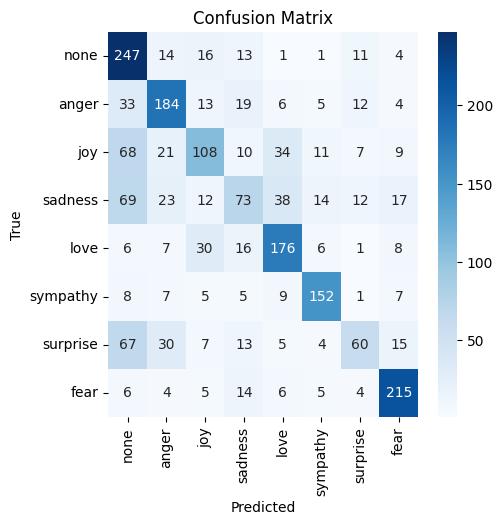

In [19]:
# creatin a confusion matrix
create_confusion_matrix(y_pred)

## Shap

In [20]:
'''
function that vectorizes the input data
then predicts using naive bayes model
parameters
texts: original text after preprocessing
'''
def model_predict(text):
  vec = tfidf_vectorizer_ls.transform(text)
  return nb_vec.predict_proba(vec)

In [21]:
'''
function that initializes shap with the appropriate model
parameters
model: an instance of your model, ex: LogisticRegression instance
'''
def initializeShap(model):
  # split input text into tokens
  masker = shap.maskers.Text(tokenizer=r"\W+")
  if isinstance(model, LogisticRegression):
    explainer = shap.Explainer(model_predict, masker=masker, output_names=label_to_class)
  elif isinstance(model, MultinomialNB):
    explainer = shap.Explainer(model_predict, masker=masker, output_names=label_to_class)
  else: print("Please use a valid model !")
  return explainer

In [22]:
nb_explainer = initializeShap(model=nb_vec)

In [23]:
def explain_example_shap(i):
  instance = df_test["Light Stemming"].iloc[i:i+1].values.astype(str).tolist()
  shap_values = nb_explainer(instance)
  shap.text_plot(shap_values)

In [24]:
y_true = df_test['label']

In [25]:
# get correctly and incorrectly classified examples
correctly_classified, incorrectly_classified = [], []
for i in range(len(y_true)):
  if y_pred[i] == y_true[i]:  correctly_classified.append(i)
  else: incorrectly_classified.append(i)

## find specific words

In [26]:
text_arabic = "الرمزنة هي خطوة مهمة في معالجة اللغة الطبيعية."

words_arabic = word_tokenize(text_arabic)

In [27]:
words_arabic

['الرمزنة', 'هي', 'خطوة', 'مهمة', 'في', 'معالجة', 'اللغة', 'الطبيعية', '.']

### loop through all incorrectly classifies examples and exctract the most common words that led to the wrong classfication

In [28]:
def get_word_frequency(df):
  # creating a dictionary to hold the number of times a specific word occurs
  word_frequency = {}
  for idx in incorrectly_classified:
    # tokenizing the words
    words_to_add = word_tokenize(df.iloc[idx])
    # looping through each word in list
    for word in words_to_add:
      if word in word_frequency:
        word_frequency[word] += 1
      else: word_frequency[word] = 1
  # soring the dictionary from most common words to least common
  sorted_list = sorted(word_frequency.items(), key=lambda word: word[1], reverse=True)
  return sorted_list

In [29]:
word_freq = get_word_frequency(df_test["cleaned_data"])

In [30]:
# getting 10 most common words
print(word_freq[:10])

[('الاوليمبياد', 247), ('فرح', 130), ('اللي', 80), ('الله', 66), ('لا', 60), ('مصر', 58), ('مش', 53), ('حب', 47), ('حزن', 43), ('الي', 32)]


### as we can see above are the most common words that lead to missclassification, lets try to understand why?

In [31]:
# see how the words above influence the classes
def word_occurance(word, df, y_pred):
  label_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
  for idx in incorrectly_classified:
    if word in df.iloc[idx]:
      label_dic[y_pred[idx]] += 1
  # create a new dictionary using label_to_class as keys
  new_dict = {label: label_dic.get(index, 0) for index, label in enumerate(label_to_class)}
  return new_dict

In [32]:
problamatic_words = [word[0] for word in word_freq[:10]]
print(problamatic_words)

['الاوليمبياد', 'فرح', 'اللي', 'الله', 'لا', 'مصر', 'مش', 'حب', 'حزن', 'الي']


In [33]:
for word in problamatic_words:
  dic = word_occurance(word, df_test["cleaned_data"], y_pred)
  print(f"Classes for Word {word}:\n{dic}", end="\n\n")

Classes for Word الاوليمبياد:
{'none': 166, 'anger': 18, 'joy': 17, 'sadness': 14, 'love': 1, 'sympathy': 1, 'surprise': 18, 'fear': 9}

Classes for Word فرح:
{'none': 45, 'anger': 3, 'joy': 8, 'sadness': 6, 'love': 2, 'sympathy': 0, 'surprise': 7, 'fear': 9}

Classes for Word اللي:
{'none': 47, 'anger': 8, 'joy': 4, 'sadness': 5, 'love': 2, 'sympathy': 1, 'surprise': 6, 'fear': 5}

Classes for Word الله:
{'none': 21, 'anger': 14, 'joy': 19, 'sadness': 7, 'love': 8, 'sympathy': 20, 'surprise': 5, 'fear': 10}

Classes for Word لا:
{'none': 203, 'anger': 55, 'joy': 46, 'sadness': 49, 'love': 47, 'sympathy': 30, 'surprise': 28, 'fear': 29}

Classes for Word مصر:
{'none': 58, 'anger': 9, 'joy': 4, 'sadness': 5, 'love': 0, 'sympathy': 0, 'surprise': 3, 'fear': 0}

Classes for Word مش:
{'none': 43, 'anger': 13, 'joy': 10, 'sadness': 9, 'love': 3, 'sympathy': 2, 'surprise': 8, 'fear': 4}

Classes for Word حب:
{'none': 15, 'anger': 9, 'joy': 16, 'sadness': 11, 'love': 36, 'sympathy': 7, 'surpr

## Misunderstanding of context

In [34]:
def explain_example_shap(i, class_to_explain):
  instance = df_test["Light Stemming"].iloc[i:i+1].values.astype(str).tolist()
  print(df_test["tweet"].iloc[i])
  shap_values = nb_explainer(instance)
  # shap.text_plot(shap_values)
  # waterfall plot
  shap.plots.waterfall(shap_values[0][:, class_to_explain])

In [35]:
def explain_example(idx):
  print(f"True Label {label_to_class_dic[y_true[idx]]} - Predicted Label {label_to_class_dic[y_pred[idx]]}")
  print(f"Explaining according to label {label_to_class_dic[y_pred[idx]]}")
  explain_example_shap(idx, y_pred[idx])

True Label joy - Predicted Label anger
Explaining according to label anger
بلاتيني يستعد ليعطي شاره انطلاق  دبي الرياضي   اخبار رياضيه  بلاتيني  دبي


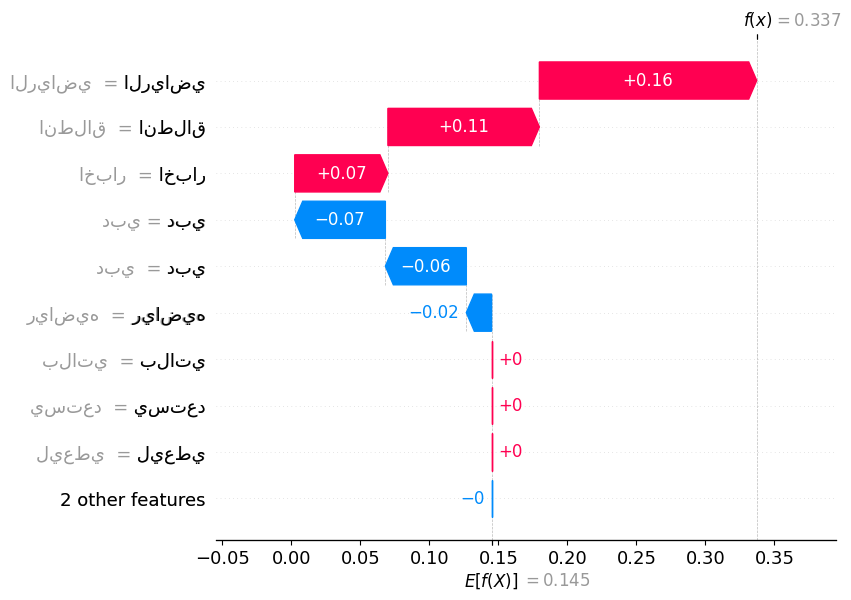

In [36]:
explain_example(incorrectly_classified[0])

about the previous example, true label is joy and it's predicted as anger, however it makes sense to be none

True Label love - Predicted Label joy
Explaining according to label joy
ايمن حفني: اصل محمد صلاح دا بالنسبالي ترامادول???????? لما بيبقي مدير فني ببقي فشيخ  باصي لعفيفي


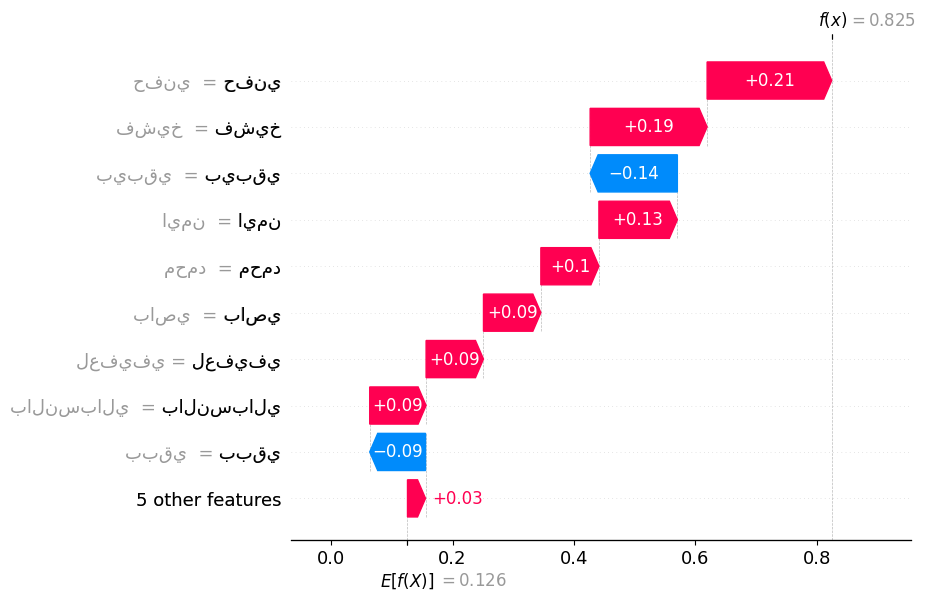

In [37]:
explain_example(incorrectly_classified[1])

here it's labeled as love and predicted as joy
however both labels here make sense and it's hard to pick one

True Label sadness - Predicted Label surprise
Explaining according to label surprise
ذهبت لكي اخبره باشتياقي .. فاصدمت .. فقد ذهب لمن خلقه ..


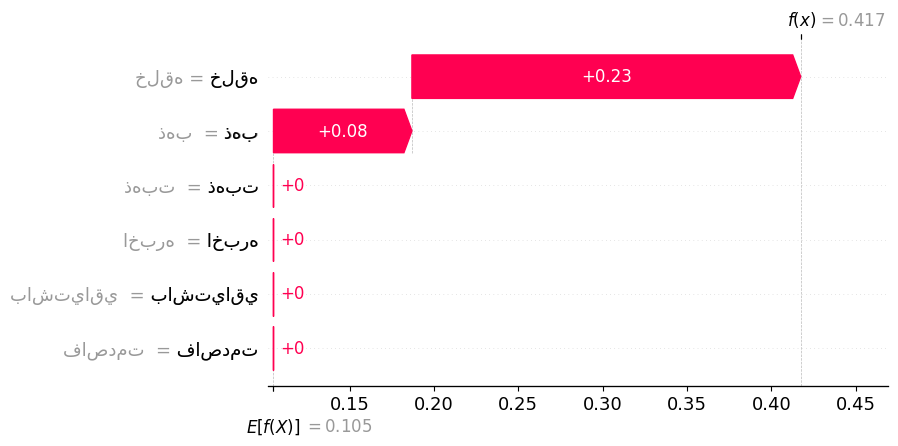

In [38]:
explain_example(incorrectly_classified[2])

here the label is sadness, but it's predicted as surprise as the word "فاصدمت" literaly means surprise, so that prediction makes more sense?

True Label none - Predicted Label anger
Explaining according to label anger
وقالت  الاوليمبياد كلمتها نعم ل  التطبيع مع اسرائيل  اسلام الشهابي  الواد الاسراييلي


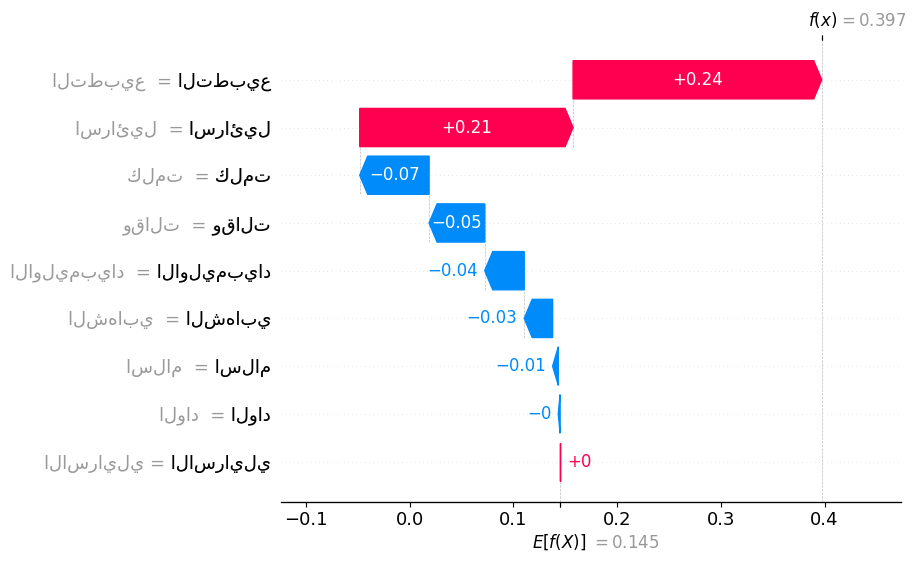

In [39]:
explain_example(incorrectly_classified[3])

here the label is none, predicted is anger, which actually makes more sense?

True Label love - Predicted Label sadness
Explaining according to label sadness
❣️ ما شرقتْ  شمسٌ و لا غربتْ الاَّ و ذكركَ مقرونًا بانفاسي و ما خلوتُ الي قومٍ احدِّثهم الاَّ و انتَ  حديثي بين جُلاَّسي ..


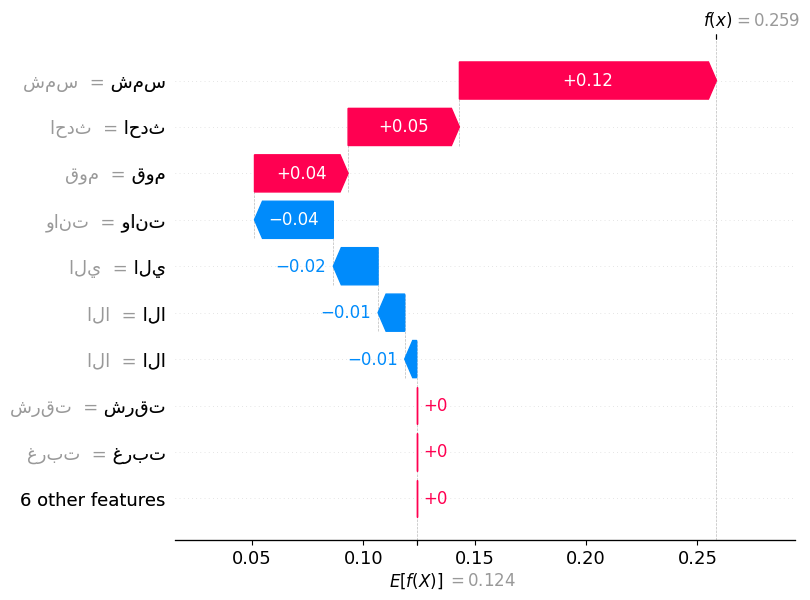

In [40]:
explain_example(incorrectly_classified[4])

here the model predicted sadness but the true label is love, the word "شمسٌ" seems to have confused the model, however "شمسٌ" shouldn't point to that label, in fact that word doesn't point to any particular emotion.

True Label joy - Predicted Label love
Explaining according to label love
ضحكتها بس لوحدها قصيــده شعــر


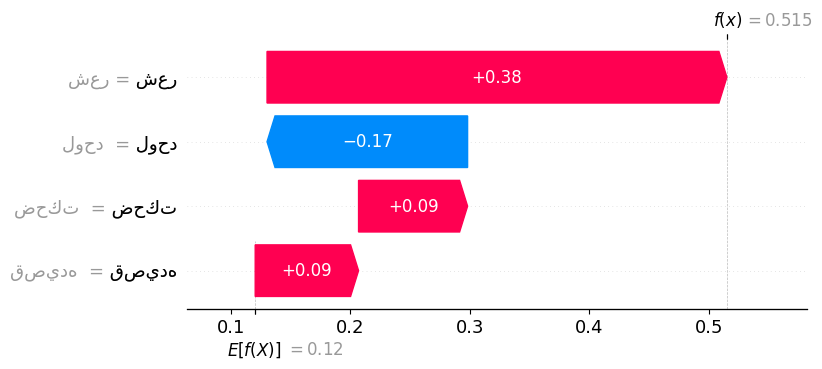

In [41]:
explain_example(incorrectly_classified[5])

above true label is joy, predicted is love.
from that statement it's obvious that it's love

#### from the above examples, it's pretty obvious that there are problems with the labeling of the examples.

#### even sometimes the model predicts the class that makes the most sense but that prediction is differenct from the 'true label' which doesn't make much sense.

#### if the model trained on poorly classified labels like this, then we predict that correcting the labels should result on better performance.

## Clearly wrong labels

True Label love - Predicted Label surprise
Explaining according to label surprise
1  ابوك* ايوا ليه؟ 2  حبييببتتي منجد???????? يالله ما احلاااك):


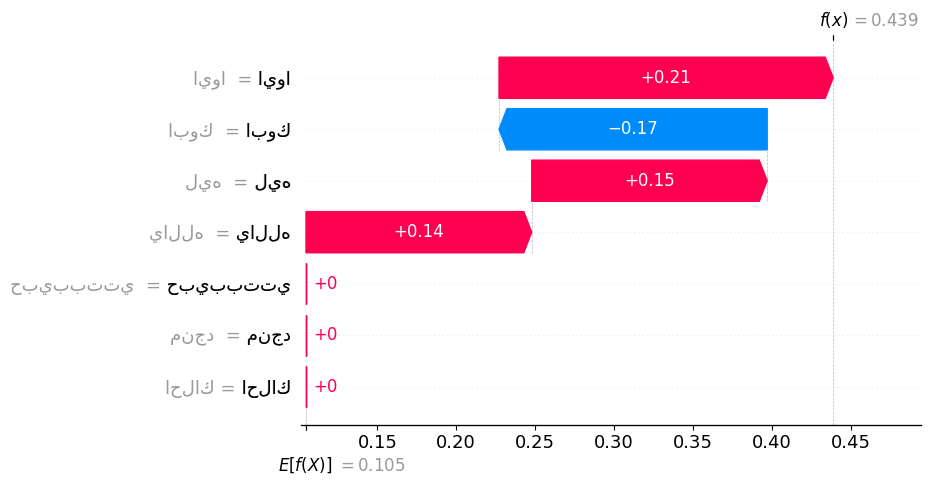

In [72]:
explain_example(incorrectly_classified[6])

## short statements

In [42]:
short_statements = []
for i in range(len(df_test)):
  if len(df_test["Light Stemming"].iloc[i]) <= 5:
    short_statements.append(i)

In [61]:
len(short_statements)

26

In [55]:
idx = 0
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

الخير
True Label: joy - Predicted Label: joy


In [56]:
idx = 1
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

غبيه
True Label: anger - Predicted Label: sadness


In [57]:
idx = 2
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

بسقط
True Label: sadness - Predicted Label: none


In [58]:
idx = 3
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

هه
True Label: joy - Predicted Label: joy


In [59]:
idx = 4
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

وقلبي
True Label: sympathy - Predicted Label: love


In [60]:
idx = 5
print(df_test["Light Stemming"].iloc[short_statements[idx]])
print(f"True Label: {label_to_class_dic[y_true[short_statements[idx]]]} - Predicted Label: {label_to_class_dic[y_pred[short_statements[idx]]]}")

خايف
True Label: fear - Predicted Label: fear


as we can see there are a lot of one word tweets and 26 tweets of length 5 or less, some of these are due to preprocessing.

## Mixed feelings

True Label sadness - Predicted Label none
Explaining according to label none
تحس لاعيبتنا ف الاوليمبياد داخله البطوله بمبدا ( عرفنا يبقي خير معرفناش يبقي لا يكلف الله نفسا الا وسعها ) فين ايام كرم حابر ميداليه ف جيبنا


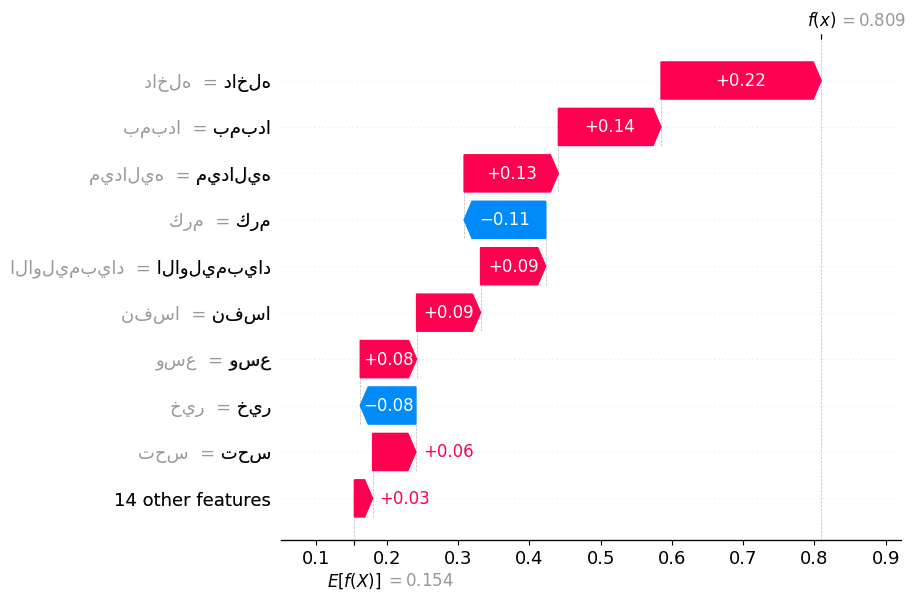

In [66]:
explain_example(incorrectly_classified[10])

True Label love - Predicted Label sadness
Explaining according to label sadness
: .. لمن يطري عليك شخص واحد وانت ساجد بين يدين ربك ..وتدعي له من كل قلبك وتنزل دموعك علشانه .  ورود الطنايا


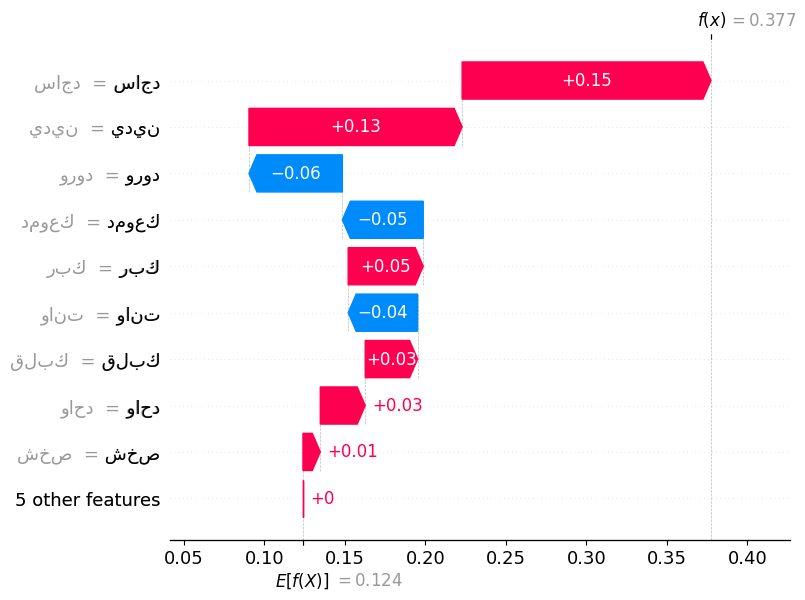

In [67]:
explain_example(incorrectly_classified[11])

here we have mixed feelings for that person that "you love" and the sadness from not having them.

True Label joy - Predicted Label none
Explaining according to label none
انا اخش اتفرج ع الاوليمبياد احسن والله .. 😂😏


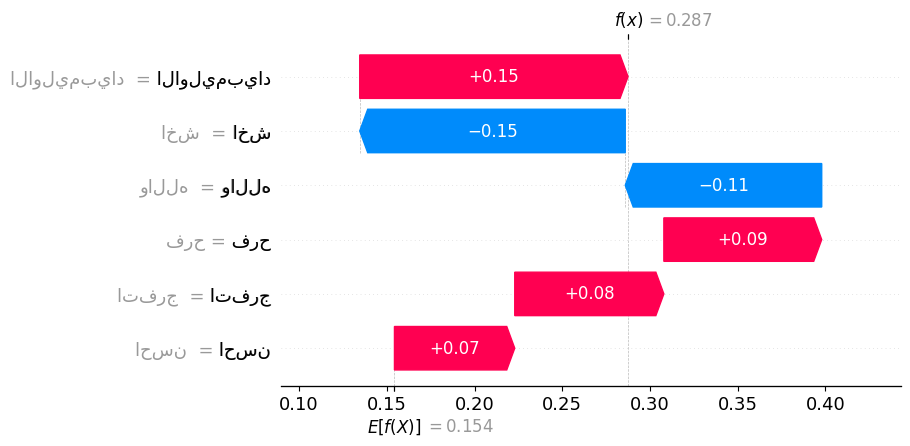

In [68]:
explain_example(incorrectly_classified[12])

True Label anger - Predicted Label none
Explaining according to label none
لماذا لا يتفق لاعبي ارسنال علي ڤينجر كما فعل لاعبوا تشيلسي الموسم الماضي مع مورينيو ليخرجوه من الفريق ؟!  wenger out


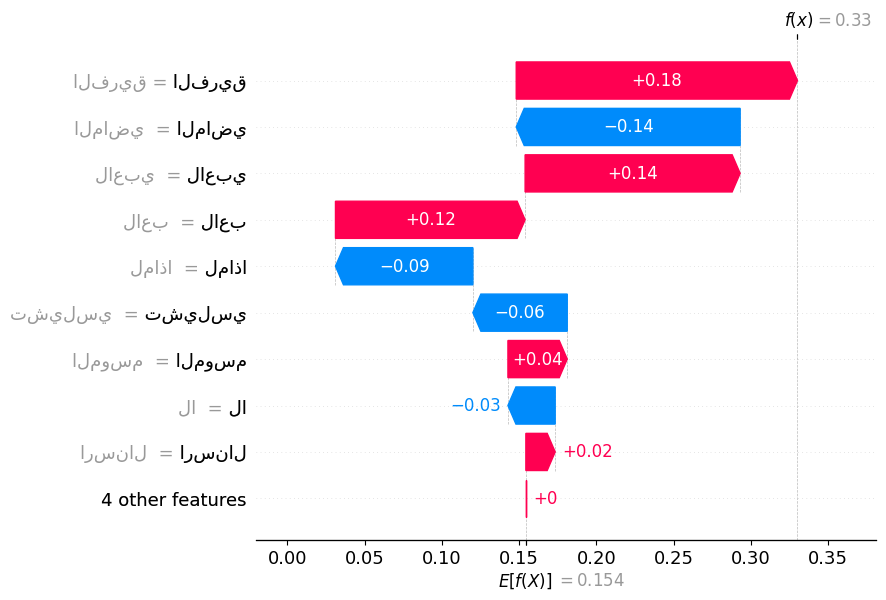

In [69]:
explain_example(incorrectly_classified[13])

True Label sadness - Predicted Label love
Explaining according to label love
:  الــــــم ااهَ يَا زمن تجمع شخص بشخص صدفہَ وتفرق ﺎلاشخاصَ بلحظہ😔💔 .


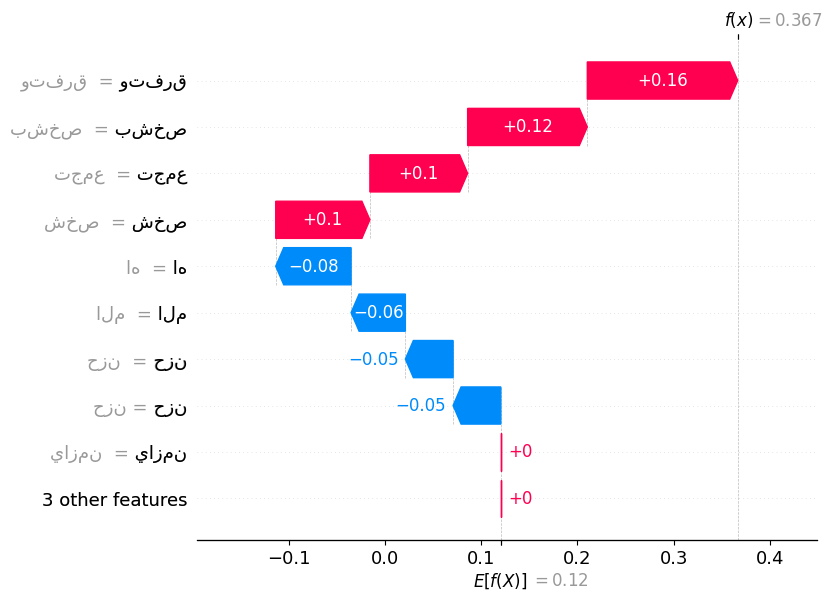

In [70]:
explain_example(incorrectly_classified[14])

True Label love - Predicted Label joy
Explaining according to label joy
: نوال الزغبي.. “كل ما بتكبر بتحلي”


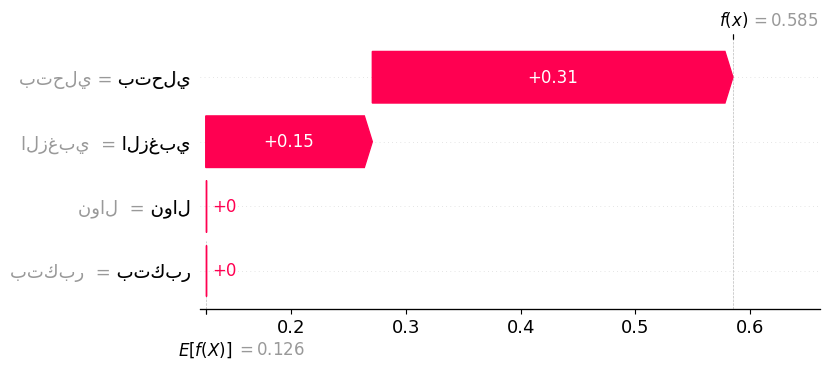

In [71]:
explain_example(incorrectly_classified[15])

## Is there a lack of sufficient training data for a particular label?

In [75]:
df_train['label'].value_counts()

0    1243
1    1168
2    1013
3     998
4     970
7     948
5     868
6     844
Name: label, dtype: int64

class surprise has almost 400 less examples than none, but is that enough to make a big difference?
however when you think about it in terms of ratio 400 is almost a third of number of examples of none.

### Observation: root stemming seems to break the words meaning and reduce accuracy below the no stemming, however light stemming seems to preserve word meaning and even improve the baseline accuracy